In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# load star image

In [125]:
PATH_IMG = r'C:\Users\sus85\OneDrive\Desktop\CV\cv_David\CV_training\data_science\5_clustering\star.jpg'
star_img = cv2.imread(PATH_IMG)
star_img = cv2.cvtColor(star_img,cv2.COLOR_BGR2RGB)
H, W, C = star_img.shape

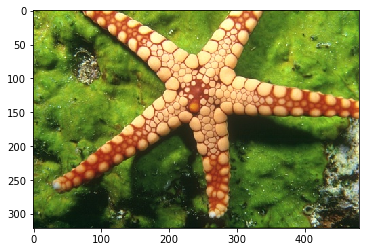

In [94]:
plt.imshow(star_img)
plt.show()

In [126]:
star_img = star_img.reshape((-1, 3))
star_img = (star_img - np.min(star_img, axis=0)) / (np.max(star_img, axis=0) - np.min(star_img, axis=0))

In [127]:
dist = []
for i in range(H):
    for j in range(W):
        dist.append(np.sqrt(i*i +j*j))

dist = np.array(dist).reshape(-1,1)    

In [128]:
dist = dist/ max(dist) # W > H

In [129]:
features = np.concatenate((star_img, dist), axis=1)

# K-means algorithm

In [130]:
def calculate_distance_vectorize(data, centroids):
    M = centroids.shape[0]
    N = data.shape[0]

    centroids_dots = (centroids * centroids).sum(axis=1).reshape((M, 1)) * np.ones(shape=(1, N))
    data_dots = (data * data).sum(axis=1) * np.ones(shape=(M, 1))
    dists = centroids_dots + data_dots - 2 * centroids.dot(data.T)
    
    return dists

def assign_to_clusters(dists):
    min_dists = np.argmin(dists, axis=0)
    idxs = np.array((range(len(min_dists))))
    clusters = [idxs[min_dists == i] for i in np.unique(min_dists)]
    return min_dists, clusters

def calculate_new_centroids(clusters, data):
    centroids = []
    for cluster in clusters:
        clusters_data = data[cluster]
        centroids.append(np.mean(clusters_data, axis=0))
    return np.array(centroids)


def kmeans(data, k):
    centroids_idx = random.sample(range(0, len(data)), k)
    centroids = data[centroids_idx] # arbitrarily choose k objects from D as the initial cluster centers
    
    while True:
        dists = calculate_distance_vectorize(data, centroids)
        labels, clusters = assign_to_clusters(dists)
        new_centroids = calculate_new_centroids(clusters, data)
        if np.array_equal(centroids, new_centroids):
            break
        else:
            centroids = new_centroids
            
    return clusters, centroids[labels.flatten()]      
        
        
    

c1, res_clusters_1 = kmeans(features, k=30)
c2, res_img_2 = kmeans(star_img, k=30)

In [131]:
res_img_1 = res_clusters_1[:,:3]


In [132]:
res_img_1 = res_img_1.reshape((H,W,C))
res_img_2 = res_img_2.reshape((H,W,C))
star_img = star_img.reshape((H,W,C))

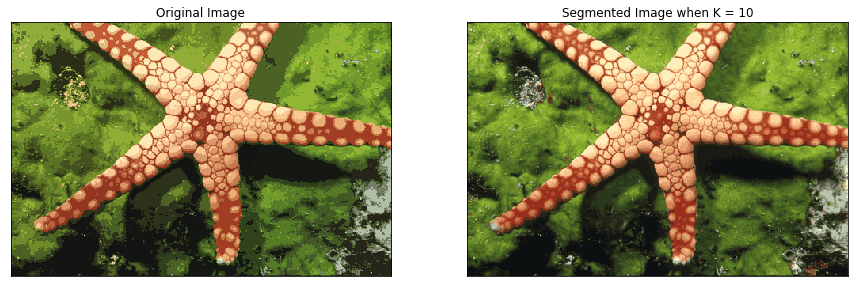

In [133]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(res_img_1)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(res_img_2)
plt.title('Segmented Image when K = %i' % 10), plt.xticks([]), plt.yticks([])
plt.show()

# Agglomerative clustering

In [13]:
star_img = star_img.reshape(-1,3)

In [152]:
def euclidean_distance(point1, point2):
    """
    Computes euclidean distance of point1 and point2.
    
    point1 and point2 are lists.
    """
    return np.linalg.norm(np.array(point1) - np.array(point2))

def clusters_distance(cluster1, cluster2):
    """
    Computes distance between two clusters.
    
    cluster1 and cluster2 are lists of lists of points
    """
    return max([euclidean_distance(point1, point2) for point1 in cluster1 for point2 in cluster2])
  
def clusters_distance_2(cluster1, cluster2):
    """
    Computes distance between two centroids of the two clusters
    
    cluster1 and cluster2 are lists of lists of points
    """
    cluster1_center = np.average(cluster1, axis=0)
    cluster2_center = np.average(cluster2, axis=0)
    return euclidean_distance(cluster1_center, cluster2_center)


class AgglomerativeClustering:
    
    def __init__(self, k, initial_k):
        self.k = k
        self.initial_k = initial_k
        
    def initial_clusters(self, points):
        
        clusters, init_clusters = kmeans(points, k=self.initial_k)
        new_clusters = []
        for cl in clusters:
            new_cluster = []
            for point in points[cl]:
                new_cluster.append(point)
                
            new_clusters.append(new_cluster)    
                
        return new_clusters        
        
    def fit(self, points):
        self.clusters_list = self.initial_clusters(points)
        while len(self.clusters_list) > self.k:

            # Find the closest (most similar) pair of clusters
            cluster1, cluster2 = min([(c1, c2) for i, c1 in enumerate(self.clusters_list) for c2 in self.clusters_list[:i]],
                 key=lambda c: clusters_distance_2(c[0], c[1]))

            # Remove the two clusters from the clusters list
            # print(np.array(cluster1).shape)
            # break
            self.clusters_list = [c for c in self.clusters_list if  not(np.array_equal(c,cluster1) or np.array_equal(c,cluster2))]

            # Merge the two clusters
            merged_cluster = cluster1 + cluster2

            # Add the merged cluster to the clusters list
            self.clusters_list.append(merged_cluster)

            print('number of clusters:', len(self.clusters_list))
        
        print('assigning cluster num to each point')
        self.cluster = {}
        for cl_num, cl in enumerate(self.clusters_list):
            for point in cl:
                self.cluster[tuple(point)] = cl_num
                
        print('Computing cluster centers')
        self.centers = {}
        for cl_num, cl in enumerate(self.clusters_list):
            self.centers[cl_num] = np.average(cl, axis=0)
            

    def predict_cluster(self, point):
        return self.cluster[tuple(point)]

    def predict_center(self, point):
        point_cluster_num = self.predict_cluster(point)
        center = self.centers[point_cluster_num]
        return center
                    

In [169]:
n_clusters = 6
agglo = AgglomerativeClustering(k=n_clusters, initial_k=40)
agglo.fit(star_img.reshape(-1,3))

number of clusters: 39
number of clusters: 38
number of clusters: 37
number of clusters: 36
number of clusters: 35
number of clusters: 34
number of clusters: 33
number of clusters: 32
number of clusters: 31
number of clusters: 30
number of clusters: 29
number of clusters: 28
number of clusters: 27
number of clusters: 26
number of clusters: 25
number of clusters: 24
number of clusters: 23
number of clusters: 22
number of clusters: 21
number of clusters: 20
number of clusters: 19
number of clusters: 18
number of clusters: 17
number of clusters: 16
number of clusters: 15
number of clusters: 14
number of clusters: 13
number of clusters: 12
number of clusters: 11
number of clusters: 10
number of clusters: 9
number of clusters: 8
number of clusters: 7
number of clusters: 6
assigning cluster num to each point
Computing cluster centers


In [170]:
new_img = [agglo.predict_center(list(pixel)) for pixel in star_img.reshape(-1,3)]
# new_img = np.array(new_img, np.uint8)

In [171]:
new_img = np.array(new_img)
res_img_1 = new_img[:,:3]
np.unique(res_img_1,axis=0)

array([[0.10924353, 0.12217181, 0.08217773],
       [0.28427344, 0.36194807, 0.13470883],
       [0.47493104, 0.60095221, 0.19094124],
       [0.6799801 , 0.32370436, 0.19428131],
       [0.83794561, 0.64529309, 0.457218  ],
       [0.97690502, 0.86447633, 0.66642333]])

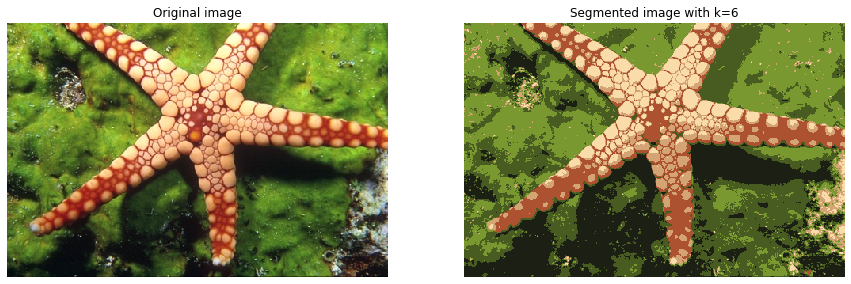

In [172]:
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(star_img.reshape(H,W,C))
plt.axis('off')
plt.title('Original image')

plt.subplot(1,2,2)
plt.imshow(res_img_1.reshape(H,W,C))
plt.axis('off')
plt.title(f'Segmented image with k={n_clusters}')

plt.show()

# cv2 kmeans sanity check

In [ ]:
star_img = star_img.reshape((-1, 3))

In [ ]:
star_img = np.float32(star_img)

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
attempts=10
ret,label,center=cv2.kmeans(star_img, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

In [ ]:
center = np.uint8(center)

In [ ]:
res = center[label.flatten()]
result_image = res.reshape((H,W,C))

In [ ]:
star_img = star_img.reshape(H,W,C) 
star_img = np.uint8(star_img)

In [ ]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(star_img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()